In [1]:
# reload modules before executing cells
%load_ext autoreload
%autoreload 2

In [2]:
from pipeline_prompt2prompt import Prompt2PromptPipeline
from ptp_utils import AttentionStore, AttentionReplace, LocalBlend, AttentionRefine, AttentionReweight, view_images, get_equalizer
import torch
import numpy as np

/opt/conda/envs/nipun/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/nipun/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [3]:
device = "cuda:1"
pipe = Prompt2PromptPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe.to(device)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Prompt2PromptPipeline {
  "_class_name": "Prompt2PromptPipeline",
  "_diffusers_version": "0.15.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
pipe.unet.attn_processors

{'down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e55a0>,
 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e53f0>,
 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e4e50>,
 'down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e4c70>,
 'down_blocks.1.attentions.0.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e5cf0>,
 'down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e5ea0>,
 'down_blocks.1.attentions.1.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor at 0x7f05033e64a0>,
 'down_blocks.1.atte

In [4]:
# # demo to show cross attention by controller
# g_cpu = torch.Generator().manual_seed(2333)
# prompts = ["A painting of a squirrel eating a burger"]
# controller = AttentionStore()


In [5]:

# # run on prompt
# outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=20,
#                 controller=controller, generator=g_cpu,)
# view_images( [np.array(img) for img in outputs.images] )
# pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0) # run only after inference once. the controller must be update to get the cross-attn map.

### Replacement edit

100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


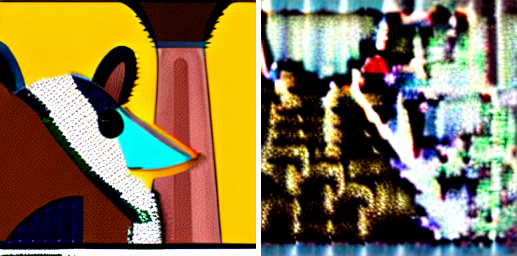

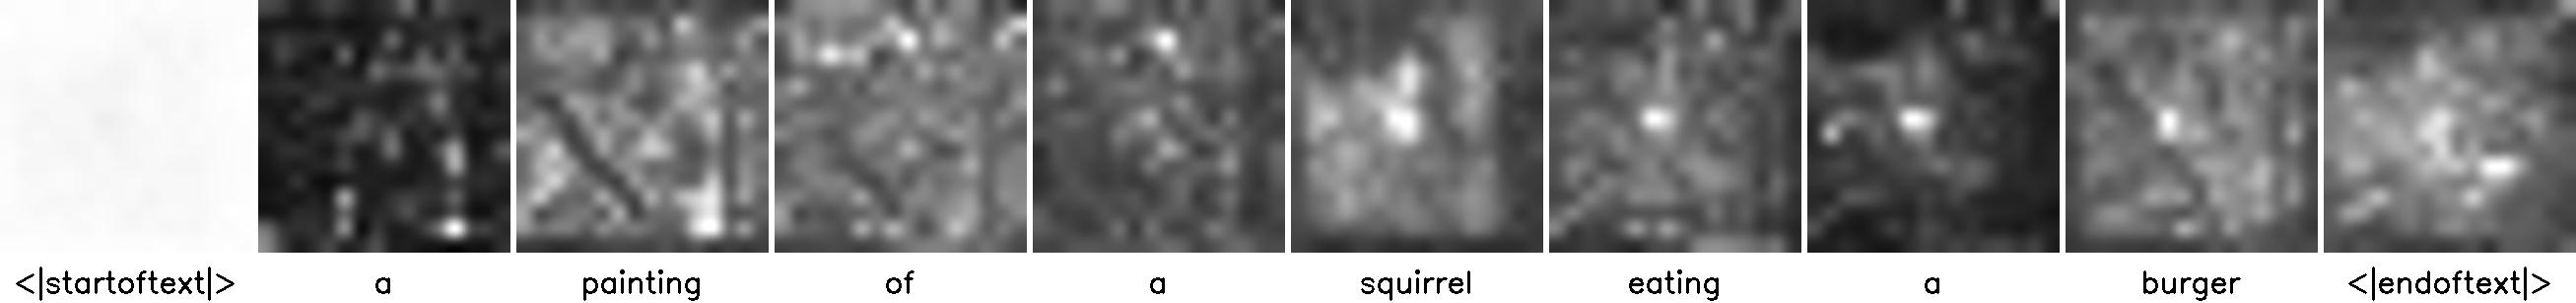

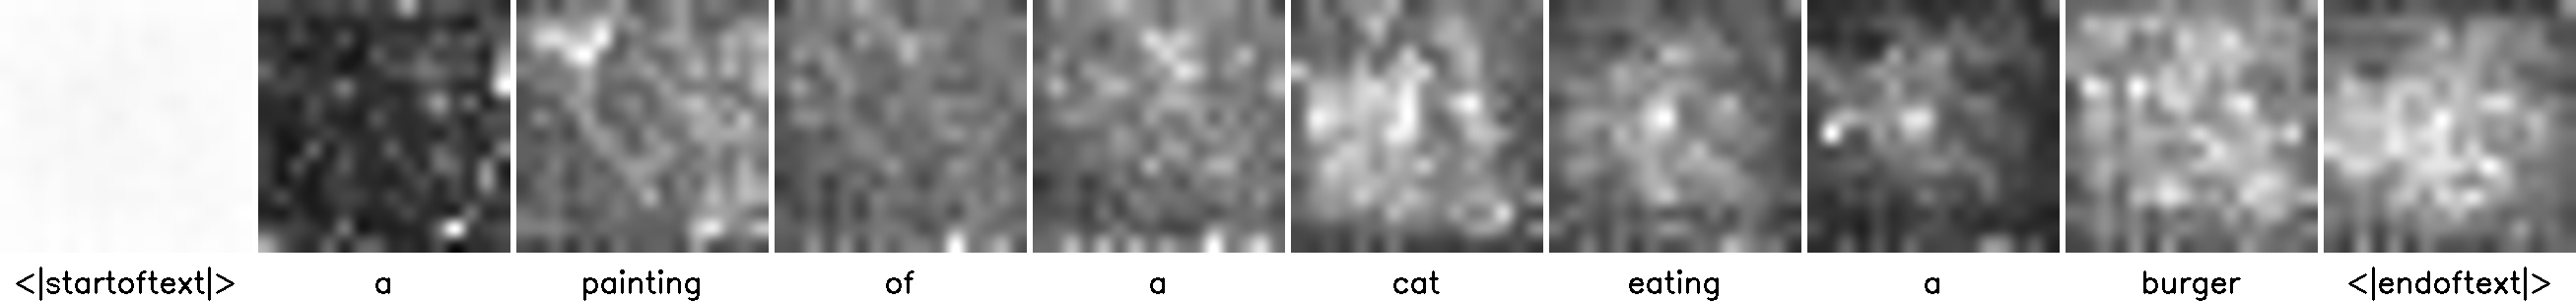

In [6]:
g_cpu = torch.Generator().manual_seed(2333)
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a cat eating a burger"]

NUM_DIFFUSION_STEPS = 20

# cross_replace_steps: specifies the fraction of steps to edit the cross attention maps. Can also be set to a dictionary [str:float] which specifies fractions for different words in the prompt.
# cross_replace_steps=0., self_replace_steps=0. means no replacement and generate a new image from scratch. you can lose the restirction by reducing the fraction.
# eg. cross_replace_steps={"default_": 1., "cat": .4} 
# self_replace_steps: specifies the fraction of steps to replace the self attention maps.

controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=0.4, self_replace_steps=0.4, tokenizer=pipe.tokenizer, device=pipe.device)
outputs = pipe(prompt=prompts, height=256, width=256, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu,)
view_images( [np.array(img) for img in outputs.images] )

pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)


In [1]:
import torch
from diffusers import DiffusionPipeline
from diffusers.utils import export_to_video

pipe = DiffusionPipeline.from_pretrained("damo-vilab/text-to-video-ms-1.7b")
pipe = pipe.to("cuda:0")

prompt = "Spiderman is surfing"
video_frames = pipe(prompt).frames
video_path = export_to_video(video_frames)
video_path

/opt/conda/envs/nipun/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]





















































































































































































Fetching 12 files:  33%|███▎      | 4/12 [00:30<01:01,  7.73s/it]






































































































































































































































































































































































































































100%|██████████| 

'/tmp/tmp0abgymbl.mp4'

In [9]:
prompt = "Darth Vader surfing a wave"
video_frames = pipe(prompt).frames
video_path = export_to_video(video_frames)
video_path

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


'/tmp/tmpfru1u3ps.mp4'

In [8]:
# display video
from IPython.display import HTML
from base64 import b64encode
video_path = "/tmp/tmplokqbhfs.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
<source src="%s" type="video/mp4">
</video>
""" % data_url)


## Replacement edit with local blend

In [ ]:
g_cpu = torch.Generator().manual_seed(2333)
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a cat eating a burger"]
from ptp_utils import AttentionReplace, LocalBlend, view_images

NUM_DIFFUSION_STEPS = 20
lb = LocalBlend(prompts, ("squirrel", "cat"), tokenizer=pipe.tokenizer, device=pipe.device)
controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.4, self_replace_steps=0.4, tokenizer=pipe.tokenizer, device=pipe.device, local_blend=lb)
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu,)
view_images( [np.array(img) for img in outputs.images] )

pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)

## Refinement edit

In [ ]:
g_cpu = torch.Generator().manual_seed(2333)
prompts = ["A painting of a squirrel eating a burger",
           "A real photo of a squirrel eating a burger"]

NUM_DIFFUSION_STEPS = 20
# lb = LocalBlend(prompts, ("squirrel", "squirrel"),tokenizer=pipe.tokenizer, device=pipe.device)   # only change the local squirrel
controller = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, 
                            cross_replace_steps=.9,
                            self_replace_steps=.2,
                            tokenizer=pipe.tokenizer,
                            device=pipe.device,)
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu,)
view_images( [np.array(img) for img in outputs.images] )
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)

## Re-weighting

In [ ]:
g_cpu = torch.Generator().manual_seed(2333)

prompts = ["a smiling pink bunny doll"] * 2
NUM_DIFFUSION_STEPS = 20

### pay less attention to the word "pink"
equalizer = get_equalizer(prompts[1], ("smiling",), (5,), tokenizer=pipe.tokenizer)

controller = AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8,
                                self_replace_steps=.8,tokenizer=pipe.tokenizer,
                                device=pipe.device,
                                equalizer=equalizer,)
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu,)
view_images( [np.array(img) for img in outputs.images] )
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)

## Multiple Controller (replace&refine + reweight)

In [ ]:
g_cpu = torch.Generator().manual_seed(2333)
NUM_DIFFUSION_STEPS = 20

prompts = ["soup",
           "pea soup with croutons"] 
lb = LocalBlend(prompts, ("soup", "soup"), tokenizer=pipe.tokenizer, device=pipe.device)

controller_a = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.2,
                            self_replace_steps=.4, local_blend=lb, tokenizer=pipe.tokenizer,
                            device=pipe.device)

outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller_a, generator=g_cpu,)                          
view_images( [np.array(img) for img in outputs.images] )
pipe.show_cross_attention(prompts, controller_a, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller_a, res=16, from_where=("up", "down"), select=1)


## add more croutons

In [ ]:
g_cpu = torch.Generator().manual_seed(2333)
NUM_DIFFUSION_STEPS = 20

prompts = ["soup",
           "pea soup with croutons"] 
lb = LocalBlend(prompts, ("soup", "soup"), tokenizer=pipe.tokenizer, device=pipe.device)

controller_a = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.2,
                            self_replace_steps=.4, local_blend=lb, tokenizer=pipe.tokenizer,
                            device=pipe.device)
# add more croutons
equalizer = get_equalizer(prompts[1], ("croutons",), (5,), tokenizer=pipe.tokenizer)
AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8,
                            self_replace_steps=.4, equalizer=equalizer, local_blend=lb,
                            controller=controller_a, tokenizer=pipe.tokenizer,
                            device=pipe.device)
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller_a, generator=g_cpu,)                          
view_images( [np.array(img) for img in outputs.images] )
pipe.show_cross_attention(prompts, controller_a, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller_a, res=16, from_where=("up", "down"), select=1)

